In [3]:
import matplotlib.pyplot as plt

# from config import settings

import pymongo
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['font.size'] = 25

# db = pymongo.MongoClient("mongodb://localhost:27017/")['Jan16_cloudseg_saliency_loss']
db = pymongo.MongoClient("mongodb://localhost:27017/")['Mar30_reducto']

10
10
10
10


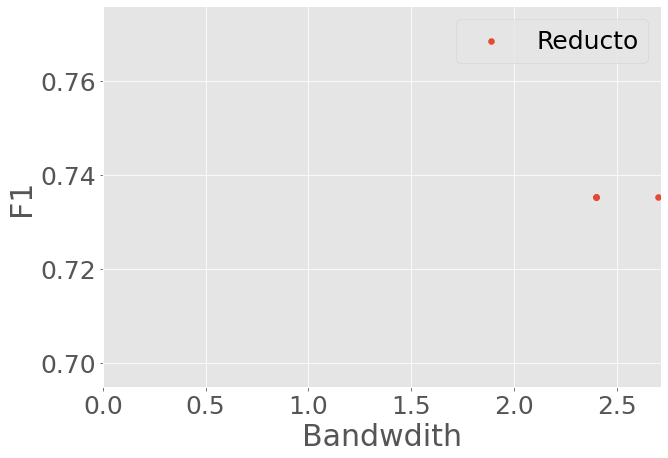

In [6]:


import numpy as np
fmt = f'videos/dashcamcropped/dashcamcropped_1_3xdownsample/part%d.mp4'
def query_approach(fmt, approach="", column='stats'):
    stats = []

    try:

        for sec in range(35, 1000):

            query = {
                'second': sec,
                'command_line_args.approach': approach,
                'command_line_args.input': fmt,
            }
            
            if isinstance(approach, dict):
                del query['command_line_args.approach']
                query['input'] = query['command_line_args.input']
                del query['command_line_args.input']
                query.update(approach)
                print(query)

            x = list(db['stats'].find(query))
            x = sorted(x, key = lambda x: x['_id'])
            stats.append(x[-1])
            
    except:
        pass

    print(len(stats))



    return np.mean([len(i['encoded_frames']) for i in stats]), np.mean([i['f1'] for i in stats])
    # return stats
    # ax[1].plot(range(len(f1s)), [i['f1'] for i in f1s], label=label)
    

fig, ax = plt.subplots(figsize=(10, 7))



# x = []
# for bw_weight in [ 0.1]:
#     loss_type = 'saliency_error'
#     approach = f'backprop_macroblocks_bwperc_{bw_weight}'
#     x.append(query_approach(fmt, approach))
    
# ax.scatter([i[0] for i in x], [i[1] for i in x], label='BP-Adapt')


# x = []
# for compute_weight in [0.5, 1, 1.5, 2]:

#     approach = f'backprop_reducto_cheap_comp_weight_{compute_weight}'
#     x.append(query_approach(fmt, approach))
#     print(x[-1])
    
    
# ax.scatter([i[0] for i in x], [i[1] for i in x], label='BP-Adapt')


x = []
for compute_weight in [0.1,  1, 10, 100]:
    for freq in [10]:
        approach = approach = f'backprop_reducto_expensive_comp_weight_{compute_weight}_freq_{freq}'
        x.append(query_approach(fmt, approach))
    
ax.scatter([i[0] for i in x], [i[1] for i in x], label='Reducto')
# stats = x[-1]
# ax.scatter(range(len(stats)), [len(i['encoded_frames']) for i in stats])


# x = [] 
# for qp in [24, 26, 28, 30, 32, 34, 36]:
#     x.append(query_approach(fmt, {'qp': qp}))
    
# print(x)
    
# ax.scatter([i[0] for i in x], [i[1] for i in x], label='MPEG')
ax.set_xlabel('Compute')
ax.set_ylabel('F1')
ax.set_xlim(left=0)
ax.legend()

0.0648665301529331 0.7293657311274729
0.08506145258921027 0.789334231188738


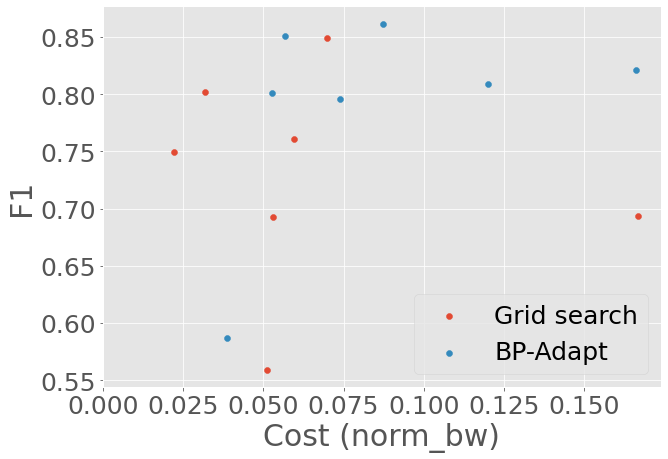

In [9]:
def calc_cost_chameleon(approach, fmt, cost_key='compute'):
    
    costs = []

    try:

        for sec in range(0, 1000):

            if sec < 9:
                continue

            query = {
                'second': sec,
                'command_line_args.approach': approach,
                'command_line_args.input': fmt,
            }

            x = list(db['cost'].find(query))
            x = sorted(x, key = lambda x: x['_id'])
            costs.append(x[-1])

    except IndexError:
        pass
    
    return np.mean([i[cost_key] for i in costs])

def calc_cost_backprop(approach, fmt, cost_key='compute'):
    
    costs = []

    try:

        for sec in range(0, 1000):

            if sec < 9:
                continue
            
            query = {
                'second': sec,
                'command_line_args.approach': approach,
                'command_line_args.input': fmt,
            }

            x = list(db['stats'].find(query))
            x = sorted(x, key = lambda x: x['_id'])
            costs.append(x[-1])
            
            if sec % 3 == 0 and sec < 20:
                costs[-1]['compute'] = len(costs[-1]['encoded_frames']) / 10 + 0.1
            else:
                costs[-1]['compute'] = len(costs[-1]['encoded_frames']) / 10

    except IndexError:
        pass
    
    return np.mean([i[cost_key] for i in costs])

fig, ax = plt.subplots(figsize=(10, 7))

compute, bw, acc = [], [], []
for idx, fmt in enumerate(fmts):
    if idx == 2:
        continue
    compute.append(calc_cost_chameleon('chameleon', fmt))
    bw.append(calc_cost_chameleon('chameleon', fmt, cost_key = 'norm_bw'))
    acc.append(calc_cost_chameleon('chameleon', fmt, cost_key = 'f1'))

ax.scatter([j for i,j in zip(bw, compute)], acc, label='Grid search')

print(np.mean([j for i,j in zip(bw, compute)]), np.mean(acc))


compute, bw, acc = [], [], []
for idx, fmt in enumerate(fmts):
    if idx == 2:
        continue
    compute.append(calc_cost_backprop(approach1, fmt))
    bw.append(calc_cost_backprop(approach1, fmt, cost_key='norm_bw'))
    acc.append(calc_cost_backprop(approach1, fmt, cost_key='f1'))

ax.scatter([j for i,j in zip(bw, compute)], acc, label='BP-Adapt')
print(np.mean([j for i,j in zip(bw, compute)]), np.mean(acc))

ax.set_xlim(left=0)
ax.set_xlabel('Cost (norm_bw)')
ax.set_ylabel('F1')

ax.legend()